# 2. Project 3: Other approaches - LeaveOneGroupOut (LOGO)

Project 3: Non-Parametric Methods
- Enrique Almazán Sánchez
- Judith Briz Galera

LeaveOneGroupOut is a variation of leave-one-out test where data points are grouped based on a specified grouping variable. In each iteration, all data points from a single group are used as the validation set, while the model is trained on the remaining groups.

It is suitable for datasets with a natural grouping structure (as 'Patient Identifier'), preventing leakage of information across groups during test evaluation.

It is also worth mentioning that it may not be as suitable for datasets without a clear grouping structure, and the effectiveness depends on the relevance of the chosen grouping variable.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils as u

# Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

# Figures of merit
from sklearn.metrics import accuracy_score

# Models to be implemented
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [2]:
import warnings

# Desactivar todas las advertencias (no se recomienda a menos que sea necesario)
warnings.filterwarnings("ignore")

## 1. Dataset import

For this approach, we need the original dataset, as the previous preprocessed one is not valid due to the split technique followed.

In [3]:
# Download the dataset as a pandas DataFrame
df = pd.read_csv("train_data.txt", header=None)

# As the dataset comes without header, we add the different names of the columns
df.columns = [
    'Patient Identifier',
    'Jitter in %',
    'Absolute Jitter in microseconds',
    'Jitter as relative amplitude perturbation',
    'Jitter as 5-point period perturbation',
    'Absolute Jitter difference between Jitter Cycles',
    'Shimmer in %','Absolute Shimmer in decibels (dB)',
    'Shimmer as 3 point amplitude perturbation',
    'Shimmer as 5 point amplitude perturbation',
    'Shimmer as 11 point amplitude perturbation',
    'Shimmer as Average absolute difference between amplitude of shimmer cycles',
    'Autocorrelation between NHR and HNR',
    'Noise to Harmonic Ratio (NHR)',
    'Harmonic to Noise Ratio (HNR)',
    'Median Pitch','Mean Pitch',
    'Standard Deviation of Pitch',
    'Minimum Pitch','Maximum Pitch',
    'Number of Pulses','Number of Periods',
    'Mean Period',
    'Standard Deviation of Period',
    'Fraction of unvoiced frames',
    'Number of voice breaks','Degree of voice break',
    'UPDRS',
    'Status'
]

Now we divide between dependent and independent variable.

In [4]:
# Dependent variable
X = df.drop(['Status', 'UPDRS'], axis=1)
# Independent variable
y = df['Status']

## 2. Preprocessing

As the raw dataset is used, it has to be preprocessed, following the procedure of Project 1. Without null or duplicate values, nor categorical data, we delve into the outlier detection field, through the Interquartile Range (IQR) method, the one chosen previously due to the results given. 

It computes outliers using the Interquartile Range (IQR) method by defining lower and upper bounds based on 1.5 times the IQR, and then identifies those which fall outside these bounds.

In [5]:
# Compute the first and third quatiles
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)

# Compute the IQR (Interquartile Range) for each column
iqr = q3 - q1

# Define the limits to find the outliers for each column
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Finding the outliers with respect the threshold based in the IQR
outliers_iqr = X[((X < lower_bound) | (X > upper_bound)).any(axis=1)]

print("Outliersfound through IQR:")
outliers_iqr

Outliersfound through IQR:


,Patient Identifier,Jitter in %,Absolute Jitter in microseconds,Jitter as relative amplitude perturbation,Jitter as 5-point period perturbation,Absolute Jitter difference between Jitter Cycles,Shimmer in %,Absolute Shimmer in decibels (dB),Shimmer as 3 point amplitude perturbation,Shimmer as 5 point amplitude perturbation,...,Standard Deviation of Pitch,Minimum Pitch,Maximum Pitch,Number of Pulses,Number of Periods,Mean Period,Standard Deviation of Period,Fraction of unvoiced frames,Number of voice breaks,Degree of voice break
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,12.981,146.445,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178
13,1,3.343,0.000164,1.349,1.826,4.047,12.619,1.316,5.287,7.670,...,21.351,156.807,239.789,205,200,0.004914,0.000616,35.849,3,29.424
14,1,2.025,0.000099,1.028,1.251,3.084,11.047,1.244,4.223,5.973,...,17.543,154.020,231.704,249,247,0.004904,0.000461,18.543,1,19.702
16,1,3.290,0.000149,1.567,1.822,4.702,12.714,1.363,4.259,6.697,...,31.456,132.023,270.998,265,260,0.004530,0.000703,37.745,3,26.397
26,2,0.427,0.000034,0.243,0.249,0.728,7.428,0.694,4.205,4.311,...,2.179,118.461,129.205,345,344,0.008073,0.000143,0.000,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,40,3.329,0.000194,1.788,2.073,5.365,12.158,1.105,5.336,6.749,...,25.881,127.375,222.632,223,217,0.005831,0.000941,29.412,4,26.510
1028,40,2.156,0.000151,0.964,0.969,2.891,14.438,1.360,5.152,8.649,...,24.849,87.010,184.012,242,237,0.007019,0.001256,14.428,3,16.947
1030,40,4.340,0.000285,1.924,2.288,5.772,13.003,1.325,5.473,8.701,...,22.658,99.126,207.647,246,238,0.006576,0.001011,34.426,5,34.510
1031,40,7.038,0.000508,3.070,2.795,9.210,19.951,1.671,10.595,14.703,...,17.066,75.966,178.374,45,42,0.007222,0.000932,13.514,1,8.920


Now we want to show the different outliers, their respective features and to which patient they belong, as well as the mean of the feature to which the outliers belong with respect to the entire dataset and the patient, in order to compare both means to see the variability.

In [6]:
# Loop through the rows with outliers
for patient_id, row in outliers_iqr.iterrows():
    # Print the patient identifier
    print(f"Patient Identifier: {row['Patient Identifier']}, with id: {round(patient_id/26)+1}")
    
    # Iterate through columns with outliers
    for column, value in row.iteritems():
        if (value < lower_bound[column]) or (value > upper_bound[column]):
            print(f"Column: {column}, Outlier Value: {value}")
            
            # Calculate the mean of the entire dataset for the specific column with the outlier
            column_mean = X[column].mean()
            
            # Calculate the mean for the patient (26 recordings) for the specific column with the outlier
            patient_recordings = X[X['Patient Identifier'] == row['Patient Identifier']]
            patient_column_mean = patient_recordings[column].mean()
            
            # Print the means
            print(f"Mean of {column} for the entire dataset: {column_mean}")
            print(f"Mean of {column} for the patient's recordings: {patient_column_mean}")
            
            # Replace the outlier value with the patient_column_mean
            X.loc[patient_id, column] = patient_column_mean

            print(f"Outlier {value} of the column {column} replaced with patient_column_mean: {patient_column_mean}")

    print()

Patient Identifier: 1.0, with id: 1
Column: Number of Pulses, Outlier Value: 1431.0
Mean of Number of Pulses for the entire dataset: 109.74423076923077
Mean of Number of Pulses for the patient's recordings: 171.5
Outlier 1431.0 of the column Number of Pulses replaced with patient_column_mean: 171.5
Column: Number of Periods, Outlier Value: 1427.0
Mean of Number of Periods for the entire dataset: 105.96923076923076
Mean of Number of Periods for the patient's recordings: 169.3846153846154
Outlier 1427.0 of the column Number of Periods replaced with patient_column_mean: 169.3846153846154

Patient Identifier: 1.0, with id: 1
Column: Number of voice breaks, Outlier Value: 3.0
Mean of Number of voice breaks for the entire dataset: 1.1346153846153846
Mean of Number of voice breaks for the patient's recordings: 0.7307692307692307
Outlier 3.0 of the column Number of voice breaks replaced with patient_column_mean: 0.7307692307692307

Patient Identifier: 1.0, with id: 2
Column: Number of Pulses, 

Outlier 6.572 of the column Jitter in % replaced with patient_column_mean: 2.7496
Column: Absolute Jitter in microseconds, Outlier Value: 0.000712761
Mean of Absolute Jitter in microseconds for the entire dataset: 0.00017039797596153883
Mean of Absolute Jitter in microseconds for the patient's recordings: 0.00025008992307692306
Outlier 0.000712761 of the column Absolute Jitter in microseconds replaced with patient_column_mean: 0.00025008992307692306
Column: Standard Deviation of Period, Outlier Value: 0.001843546
Mean of Standard Deviation of Period for the entire dataset: 0.0008337940767424328
Mean of Standard Deviation of Period for the patient's recordings: 0.0007282265992831134
Outlier 0.001843546 of the column Standard Deviation of Period replaced with patient_column_mean: 0.0007282265992831134

Patient Identifier: 5.0, with id: 6
Column: Absolute Jitter in microseconds, Outlier Value: 0.000458914
Mean of Absolute Jitter in microseconds for the entire dataset: 0.000169953099926035

Outlier 5.0 of the column Number of voice breaks replaced with patient_column_mean: 1.0252507790343475

Patient Identifier: 11.0, with id: 11
Column: Harmonic to Noise Ratio (HNR), Outlier Value: 19.167
Mean of Harmonic to Noise Ratio (HNR) for the entire dataset: 9.92978805770764
Mean of Harmonic to Noise Ratio (HNR) for the patient's recordings: 11.107769230769232
Outlier 19.167 of the column Harmonic to Noise Ratio (HNR) replaced with patient_column_mean: 11.107769230769232

Patient Identifier: 11.0, with id: 11
Column: Harmonic to Noise Ratio (HNR), Outlier Value: 23.021
Mean of Harmonic to Noise Ratio (HNR) for the entire dataset: 9.92203879735261
Mean of Harmonic to Noise Ratio (HNR) for the patient's recordings: 10.797798816568047
Outlier 23.021 of the column Harmonic to Noise Ratio (HNR) replaced with patient_column_mean: 10.797798816568047

Patient Identifier: 11.0, with id: 11
Column: Harmonic to Noise Ratio (HNR), Outlier Value: 24.532
Mean of Harmonic to Noise Ratio (HNR) f

Mean of Standard Deviation of Pitch for the entire dataset: 24.788734310589103
Mean of Standard Deviation of Pitch for the patient's recordings: 23.995038461538464
Outlier 65.622 of the column Standard Deviation of Pitch replaced with patient_column_mean: 23.995038461538464
Column: Maximum Pitch, Outlier Value: 493.154
Mean of Maximum Pitch for the entire dataset: 226.47676234209305
Mean of Maximum Pitch for the patient's recordings: 263.4630384615385
Outlier 493.154 of the column Maximum Pitch replaced with patient_column_mean: 263.4630384615385

Patient Identifier: 13.0, with id: 13
Column: Maximum Pitch, Outlier Value: 479.673
Mean of Maximum Pitch for the entire dataset: 226.25590564830608
Mean of Maximum Pitch for the patient's recordings: 254.6287707100592
Outlier 479.673 of the column Maximum Pitch replaced with patient_column_mean: 254.6287707100592
Column: Number of voice breaks, Outlier Value: 5.0
Mean of Number of voice breaks for the entire dataset: 1.0229882371817898
Mean 

Mean of Standard Deviation of Pitch for the entire dataset: 24.16165957336591
Mean of Standard Deviation of Pitch for the patient's recordings: 23.272189178425126
Outlier 94.403 of the column Standard Deviation of Pitch replaced with patient_column_mean: 23.272189178425126
Column: Maximum Pitch, Outlier Value: 490.249
Mean of Maximum Pitch for the entire dataset: 224.07266238669018
Mean of Maximum Pitch for the patient's recordings: 196.16915384615382
Outlier 490.249 of the column Maximum Pitch replaced with patient_column_mean: 196.16915384615382
Column: Standard Deviation of Period, Outlier Value: 0.002988242
Mean of Standard Deviation of Period for the entire dataset: 0.0007913499148115916
Mean of Standard Deviation of Period for the patient's recordings: 0.0010654235240100138
Outlier 0.002988242 of the column Standard Deviation of Period replaced with patient_column_mean: 0.0010654235240100138

Patient Identifier: 16.0, with id: 16
Column: Standard Deviation of Pitch, Outlier Value

Mean of Shimmer as 5 point amplitude perturbation for the entire dataset: 7.896704742785611
Mean of Shimmer as 5 point amplitude perturbation for the patient's recordings: 12.853961054619761
Outlier 18.208 of the column Shimmer as 5 point amplitude perturbation replaced with patient_column_mean: 12.853961054619761
Column: Noise to Harmonic Ratio (NHR), Outlier Value: 0.568875
Mean of Noise to Harmonic Ratio (NHR) for the entire dataset: 0.2291688800352319
Mean of Noise to Harmonic Ratio (NHR) for the patient's recordings: 0.4120320441926184
Outlier 0.568875 of the column Noise to Harmonic Ratio (NHR) replaced with patient_column_mean: 0.4120320441926184
Column: Standard Deviation of Pitch, Outlier Value: 110.97
Mean of Standard Deviation of Pitch for the entire dataset: 23.674656461404076
Mean of Standard Deviation of Pitch for the patient's recordings: 36.61515550522094
Outlier 110.97 of the column Standard Deviation of Pitch replaced with patient_column_mean: 36.61515550522094
Column

Mean of Jitter as relative amplitude perturbation for the entire dataset: 1.2124530490123497
Mean of Jitter as relative amplitude perturbation for the patient's recordings: 2.494141564068334
Outlier 3.953 of the column Jitter as relative amplitude perturbation replaced with patient_column_mean: 2.494141564068334
Column: Jitter as 5-point period perturbation, Outlier Value: 3.376
Mean of Jitter as 5-point period perturbation for the entire dataset: 1.2992793108393652
Mean of Jitter as 5-point period perturbation for the patient's recordings: 2.283412837143205
Outlier 3.376 of the column Jitter as 5-point period perturbation replaced with patient_column_mean: 2.283412837143205
Column: Absolute Jitter difference between Jitter Cycles, Outlier Value: 11.858
Mean of Absolute Jitter difference between Jitter Cycles for the entire dataset: 3.637361466273656
Mean of Absolute Jitter difference between Jitter Cycles for the patient's recordings: 7.482410129899066
Outlier 11.858 of the column Abs

Mean of Shimmer as 11 point amplitude perturbation for the entire dataset: 11.953730031724987
Mean of Shimmer as 11 point amplitude perturbation for the patient's recordings: 10.485360000000002
Outlier 27.89 of the column Shimmer as 11 point amplitude perturbation replaced with patient_column_mean: 10.485360000000002
Column: Standard Deviation of Pitch, Outlier Value: 68.724
Mean of Standard Deviation of Pitch for the entire dataset: 23.103043131981952
Mean of Standard Deviation of Pitch for the patient's recordings: 42.574423076923075
Outlier 68.724 of the column Standard Deviation of Pitch replaced with patient_column_mean: 42.574423076923075
Column: Standard Deviation of Period, Outlier Value: 0.002114714
Mean of Standard Deviation of Period for the entire dataset: 0.0007657895949955478
Mean of Standard Deviation of Period for the patient's recordings: 0.0014486780384615383
Outlier 0.002114714 of the column Standard Deviation of Period replaced with patient_column_mean: 0.0014486780

Mean of Maximum Pitch for the entire dataset: 218.50439861353047
Mean of Maximum Pitch for the patient's recordings: 205.97342959610208
Outlier 484.366 of the column Maximum Pitch replaced with patient_column_mean: 205.97342959610208
Column: Standard Deviation of Period, Outlier Value: 0.003540767
Mean of Standard Deviation of Period for the entire dataset: 0.0007556092073521488
Mean of Standard Deviation of Period for the patient's recordings: 0.001041462532725569
Outlier 0.003540767 of the column Standard Deviation of Period replaced with patient_column_mean: 0.001041462532725569

Patient Identifier: 22.0, with id: 23
Column: Standard Deviation of Pitch, Outlier Value: 105.825
Mean of Standard Deviation of Pitch for the entire dataset: 22.63409302066133
Mean of Standard Deviation of Pitch for the patient's recordings: 23.816418624098397
Outlier 105.825 of the column Standard Deviation of Pitch replaced with patient_column_mean: 23.816418624098397
Column: Maximum Pitch, Outlier Value:

Mean of Shimmer in % for the entire dataset: 12.84240477661662
Mean of Shimmer in % for the patient's recordings: 13.883076923076924
Outlier 28.513 of the column Shimmer in % replaced with patient_column_mean: 13.883076923076924
Column: Absolute Shimmer in decibels (dB), Outlier Value: 2.262
Mean of Absolute Shimmer in decibels (dB) for the entire dataset: 1.1924373819434715
Mean of Absolute Shimmer in decibels (dB) for the patient's recordings: 1.237153846153846
Outlier 2.262 of the column Absolute Shimmer in decibels (dB) replaced with patient_column_mean: 1.237153846153846
Column: Shimmer as 3 point amplitude perturbation, Outlier Value: 18.772
Mean of Shimmer as 3 point amplitude perturbation for the entire dataset: 5.637661507761584
Mean of Shimmer as 3 point amplitude perturbation for the patient's recordings: 6.869615384615383
Outlier 18.772 of the column Shimmer as 3 point amplitude perturbation replaced with patient_column_mean: 6.869615384615383
Column: Shimmer as 5 point amp

Outlier 67.555 of the column Standard Deviation of Pitch replaced with patient_column_mean: 23.173263313609464
Column: Standard Deviation of Period, Outlier Value: 0.002914887
Mean of Standard Deviation of Period for the entire dataset: 0.0007364424381469491
Mean of Standard Deviation of Period for the patient's recordings: 0.001143435545857988
Outlier 0.002914887 of the column Standard Deviation of Period replaced with patient_column_mean: 0.001143435545857988

Patient Identifier: 27.0, with id: 28
Column: Shimmer as 11 point amplitude perturbation, Outlier Value: 33.319
Mean of Shimmer as 11 point amplitude perturbation for the entire dataset: 11.875239029773919
Mean of Shimmer as 11 point amplitude perturbation for the patient's recordings: 11.392318181538458
Outlier 33.319 of the column Shimmer as 11 point amplitude perturbation replaced with patient_column_mean: 11.392318181538458
Column: Standard Deviation of Pitch, Outlier Value: 135.473
Mean of Standard Deviation of Pitch for t

Outlier 18.366 of the column Shimmer as 5 point amplitude perturbation replaced with patient_column_mean: 19.65772727230769
Column: Shimmer as Average absolute difference between amplitude of shimmer cycles, Outlier Value: 36.54
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the entire dataset: 16.816390501138684
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the patient's recordings: 33.80161538461538
Outlier 36.54 of the column Shimmer as Average absolute difference between amplitude of shimmer cycles replaced with patient_column_mean: 33.80161538461538
Column: Autocorrelation between NHR and HNR, Outlier Value: 0.620008
Mean of Autocorrelation between NHR and HNR for the entire dataset: 0.8470351047426293
Mean of Autocorrelation between NHR and HNR for the patient's recordings: 0.6850068846153845
Outlier 0.620008 of the column Autocorrelation between NHR and HNR replaced with patient_column_mean: 0.68500

Mean of Mean Pitch for the entire dataset: 168.0056183181612
Mean of Mean Pitch for the patient's recordings: 249.56353846153849
Outlier 361.507 of the column Mean Pitch replaced with patient_column_mean: 249.56353846153849
Column: Standard Deviation of Pitch, Outlier Value: 143.785
Mean of Standard Deviation of Pitch for the entire dataset: 20.675257391657954
Mean of Standard Deviation of Pitch for the patient's recordings: 74.33319082840238
Outlier 143.785 of the column Standard Deviation of Pitch replaced with patient_column_mean: 74.33319082840238
Column: Maximum Pitch, Outlier Value: 504.69
Mean of Maximum Pitch for the entire dataset: 210.6663958099956
Mean of Maximum Pitch for the patient's recordings: 373.3702278106508
Outlier 504.69 of the column Maximum Pitch replaced with patient_column_mean: 373.3702278106508

Patient Identifier: 31.0, with id: 31
Column: Shimmer as 3 point amplitude perturbation, Outlier Value: 12.145
Mean of Shimmer as 3 point amplitude perturbation for t

Mean of Shimmer as 3 point amplitude perturbation for the entire dataset: 5.5690544581170816
Mean of Shimmer as 3 point amplitude perturbation for the patient's recordings: 9.811425114811595
Outlier 16.875 of the column Shimmer as 3 point amplitude perturbation replaced with patient_column_mean: 9.811425114811595
Column: Shimmer as 5 point amplitude perturbation, Outlier Value: 29.087
Mean of Shimmer as 5 point amplitude perturbation for the entire dataset: 7.791489484160265
Mean of Shimmer as 5 point amplitude perturbation for the patient's recordings: 17.014421778108172
Outlier 29.087 of the column Shimmer as 5 point amplitude perturbation replaced with patient_column_mean: 17.014421778108172
Column: Shimmer as Average absolute difference between amplitude of shimmer cycles, Outlier Value: 50.626
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the entire dataset: 16.7072044451642
Mean of Shimmer as Average absolute difference between amplitude o

Mean of Noise to Harmonic Ratio (NHR) for the entire dataset: 0.2262375026770879
Mean of Noise to Harmonic Ratio (NHR) for the patient's recordings: 0.5806811005917161
Outlier 0.74109 of the column Noise to Harmonic Ratio (NHR) replaced with patient_column_mean: 0.5806811005917161
Column: Standard Deviation of Pitch, Outlier Value: 99.855
Mean of Standard Deviation of Pitch for the entire dataset: 19.83610167732643
Mean of Standard Deviation of Pitch for the patient's recordings: 63.399747269003186
Outlier 99.855 of the column Standard Deviation of Pitch replaced with patient_column_mean: 63.399747269003186
Column: Maximum Pitch, Outlier Value: 467.415
Mean of Maximum Pitch for the entire dataset: 208.72928722841954
Mean of Maximum Pitch for the patient's recordings: 365.04646956076465
Outlier 467.415 of the column Maximum Pitch replaced with patient_column_mean: 365.04646956076465
Column: Standard Deviation of Period, Outlier Value: 0.002046647
Mean of Standard Deviation of Period for

Mean of Standard Deviation of Pitch for the patient's recordings: 49.97138508901921
Outlier 152.268 of the column Standard Deviation of Pitch replaced with patient_column_mean: 49.97138508901921
Column: Maximum Pitch, Outlier Value: 493.901
Mean of Maximum Pitch for the entire dataset: 207.49885597540117
Mean of Maximum Pitch for the patient's recordings: 315.82921944003016
Outlier 493.901 of the column Maximum Pitch replaced with patient_column_mean: 315.82921944003016
Column: Standard Deviation of Period, Outlier Value: 0.002286039
Mean of Standard Deviation of Period for the entire dataset: 0.0007124265870828157
Mean of Standard Deviation of Period for the patient's recordings: 0.0010256978472647446
Outlier 0.002286039 of the column Standard Deviation of Period replaced with patient_column_mean: 0.0010256978472647446
Column: Number of voice breaks, Outlier Value: 5.0
Mean of Number of voice breaks for the entire dataset: 0.7946548036825762
Mean of Number of voice breaks for the pati

Mean of Shimmer as 3 point amplitude perturbation for the entire dataset: 5.525617871535084
Mean of Shimmer as 3 point amplitude perturbation for the patient's recordings: 10.932368295470091
Outlier 14.154 of the column Shimmer as 3 point amplitude perturbation replaced with patient_column_mean: 10.932368295470091
Column: Shimmer as Average absolute difference between amplitude of shimmer cycles, Outlier Value: 42.462
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the entire dataset: 16.576897816665863
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the patient's recordings: 32.79723962823403
Outlier 42.462 of the column Shimmer as Average absolute difference between amplitude of shimmer cycles replaced with patient_column_mean: 32.79723962823403
Column: Standard Deviation of Pitch, Outlier Value: 140.295
Mean of Standard Deviation of Pitch for the entire dataset: 19.240345200749235
Mean of Standard Deviatio

Mean of Noise to Harmonic Ratio (NHR) for the entire dataset: 0.22247218291204737
Mean of Noise to Harmonic Ratio (NHR) for the patient's recordings: 0.41616812456212104
Outlier 0.560299 of the column Noise to Harmonic Ratio (NHR) replaced with patient_column_mean: 0.41616812456212104
Column: Standard Deviation of Pitch, Outlier Value: 149.145
Mean of Standard Deviation of Pitch for the entire dataset: 18.74755804272801
Mean of Standard Deviation of Pitch for the patient's recordings: 60.432093745846764
Outlier 149.145 of the column Standard Deviation of Pitch replaced with patient_column_mean: 60.432093745846764
Column: Maximum Pitch, Outlier Value: 491.975
Mean of Maximum Pitch for the entire dataset: 205.902166259517
Mean of Maximum Pitch for the patient's recordings: 346.48353421125705
Outlier 491.975 of the column Maximum Pitch replaced with patient_column_mean: 346.48353421125705
Column: Number of Pulses, Outlier Value: 254.0
Mean of Number of Pulses for the entire dataset: 82.77

Mean of Shimmer as 5 point amplitude perturbation for the entire dataset: 7.659383073979906
Mean of Shimmer as 5 point amplitude perturbation for the patient's recordings: 12.171786240078587
Outlier 22.211 of the column Shimmer as 5 point amplitude perturbation replaced with patient_column_mean: 12.171786240078587
Column: Shimmer as Average absolute difference between amplitude of shimmer cycles, Outlier Value: 38.181
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the entire dataset: 16.44070439519065
Mean of Shimmer as Average absolute difference between amplitude of shimmer cycles for the patient's recordings: 25.634938916269395
Outlier 38.181 of the column Shimmer as Average absolute difference between amplitude of shimmer cycles replaced with patient_column_mean: 25.634938916269395

Patient Identifier: 33.0, with id: 34
Column: Maximum Pitch, Outlier Value: 465.093
Mean of Maximum Pitch for the entire dataset: 205.1464408442596
Mean of Maximu

Mean of Number of Pulses for the entire dataset: 78.19438330423294
Mean of Number of Pulses for the patient's recordings: 82.92307692307692
Outlier 241.0 of the column Number of Pulses replaced with patient_column_mean: 82.92307692307692
Column: Number of Periods, Outlier Value: 240.0
Mean of Number of Periods for the entire dataset: 74.98403220056711
Mean of Number of Periods for the patient's recordings: 80.61538461538461
Outlier 240.0 of the column Number of Periods replaced with patient_column_mean: 80.61538461538461

Patient Identifier: 39.0, with id: 39
Column: Number of Periods, Outlier Value: 213.0
Mean of Number of Periods for the entire dataset: 74.83077776269731
Mean of Number of Periods for the patient's recordings: 74.48520710059172
Outlier 213.0 of the column Number of Periods replaced with patient_column_mean: 74.48520710059172

Patient Identifier: 39.0, with id: 39
Column: Harmonic to Noise Ratio (HNR), Outlier Value: 19.5
Mean of Harmonic to Noise Ratio (HNR) for the e

Mean of Number of voice breaks for the entire dataset: 0.6889885540573061
Mean of Number of voice breaks for the patient's recordings: 1.072563985854837
Outlier 3.0 of the column Number of voice breaks replaced with patient_column_mean: 1.072563985854837



## 3. Feature Selection

First of all, the column 'Patient Identifier' is eliminated, as it does not give any valuable information.

In [7]:
patient_id_train = X['Patient Identifier']
patient_id_train.columns = 'Patient Identifier'
X = X.drop('Patient Identifier', axis=1)

### 3.1. Correlation between features and their importance regarding the estimation of the target variable.

First, we compute the importance of each feature.

In [8]:
# Create and fit the classifier
clf = ExtraTreesClassifier(n_estimators=50, random_state=10)
clf = clf.fit(X, y)

# Create and fit SelectFromModel with feature names
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

# Get feature importances for all features
importances = dict(zip(X.columns, clf.feature_importances_))

And we show the results.

In [9]:
# Find the maximum width of the keys for formatting
max_key_width = max(map(len, importances.keys()))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Jitter in %                                                                 0.039
Absolute Jitter in microseconds                                             0.036
Jitter as relative amplitude perturbation                                   0.048
Jitter as 5-point period perturbation                                       0.042
Absolute Jitter difference between Jitter Cycles                            0.041
Shimmer in %                                                                0.034
Absolute Shimmer in decibels (dB)                                           0.036
Shimmer as 3 point amplitude perturbation                                   0.035
Shimmer as 5 point amplitude perturbation                                   0.035
Shimmer as 11 point amplitude perturbation                                  0.047
Shimmer as Average absolute difference between amplitude of shimmer cycles  0.031
Autocorrelation between NHR and HNR                                         0.04
Noise to Harmonic

The correlation matrix is shown in the first jupyter notebook, thus, we show the different groups of features which have high correletion between them.

In [10]:
# Creamos una lista con las columnas/características
columns = list(X.columns)

# Creamos un diccionario para almacenar los grupos de columnas altamente correlacionadas
correlation_groups = {}

# Iteramos sobre las columnas de la lista creada previamente
for column in columns:
    
    # Flag para indicar si la columna está asignada a un grupo existente
    assigned_to_group = False
    
    # Iteramos sobre los grupos existentes
    for group, group_columns in correlation_groups.items():
        
        # Calculamos la correlación promedio entre la columna actual y las columnas del grupo
        avg_correlation = sum(X[column].corr(X[col]) for col in group_columns) / len(group_columns)
        
        # Si la correlación promedio es mayor que un umbral, asignamos la columna al grupo
        if avg_correlation > 0.8 or avg_correlation < -0.75:
            correlation_groups[group].append(column)
            assigned_to_group = True
            break
    
    # Si la columna no se asigna a un grupo existente, creamos un nuevo grupo
    if not assigned_to_group:
        correlation_groups[column] = [column]

In [11]:
# Showing the resulting groups
for i, (group, group_columns) in enumerate(correlation_groups.items()):
    print(f"\n{i+1} Group {group}: {group_columns}")


1 Group Jitter in %: ['Jitter in %', 'Absolute Jitter in microseconds', 'Jitter as relative amplitude perturbation', 'Jitter as 5-point period perturbation', 'Absolute Jitter difference between Jitter Cycles']

2 Group Shimmer in %: ['Shimmer in %', 'Absolute Shimmer in decibels (dB)', 'Shimmer as 3 point amplitude perturbation', 'Shimmer as 5 point amplitude perturbation', 'Shimmer as Average absolute difference between amplitude of shimmer cycles']

3 Group Shimmer as 11 point amplitude perturbation: ['Shimmer as 11 point amplitude perturbation']

4 Group Autocorrelation between NHR and HNR: ['Autocorrelation between NHR and HNR', 'Noise to Harmonic Ratio (NHR)']

5 Group Harmonic to Noise Ratio (HNR): ['Harmonic to Noise Ratio (HNR)']

6 Group Median Pitch: ['Median Pitch', 'Mean Pitch', 'Minimum Pitch', 'Mean Period']

7 Group Standard Deviation of Pitch: ['Standard Deviation of Pitch']

8 Group Maximum Pitch: ['Maximum Pitch']

9 Group Number of Pulses: ['Number of Pulses', 'Numb

Now we select one feature per correlation group, which is the one with more importance per group.

In [12]:
# Create a list to add the best features
best_features = []

# Iterating over the correlation_groups as a dictionary of groups of correlated features
# (the created in the previous example)
for group, group_columns in correlation_groups.items():
    # Find the feature with the highest importance in the current group
    best_features.append(max(group_columns, key=lambda x: importances[x]))

We show the selected features.

In [13]:
# Show the features selected
for i, feature in enumerate(best_features):
    print(f"Best feature for group {i+1}: {feature}")

Best feature for group 1: Jitter as relative amplitude perturbation
Best feature for group 2: Absolute Shimmer in decibels (dB)
Best feature for group 3: Shimmer as 11 point amplitude perturbation
Best feature for group 4: Autocorrelation between NHR and HNR
Best feature for group 5: Harmonic to Noise Ratio (HNR)
Best feature for group 6: Median Pitch
Best feature for group 7: Standard Deviation of Pitch
Best feature for group 8: Maximum Pitch
Best feature for group 9: Number of Pulses
Best feature for group 10: Standard Deviation of Period
Best feature for group 11: Fraction of unvoiced frames
Best feature for group 12: Number of voice breaks
Best feature for group 13: Degree of voice break


In [14]:
clf = clf.fit(X[best_features], y)

# Get feature importances for best features
importances = dict(zip(X[best_features].columns, clf.feature_importances_))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Jitter as relative amplitude perturbation                                   0.1
Absolute Shimmer in decibels (dB)                                           0.078
Shimmer as 11 point amplitude perturbation                                  0.096
Autocorrelation between NHR and HNR                                         0.078
Harmonic to Noise Ratio (HNR)                                               0.074
Median Pitch                                                                0.084
Standard Deviation of Pitch                                                 0.084
Maximum Pitch                                                               0.092
Number of Pulses                                                            0.071
Standard Deviation of Period                                                0.073
Fraction of unvoiced frames                                                 0.078
Number of voice breaks                                                      0.044
Degree of voice br

As it can be seen, it does not change from the results obtained when doing feature selection applied to a differentiate train and test subset (first document).

## 4. Presentation of the methods

The methods presented below have already been explained in the 'README' document. Also, their hyperparamters have been established by basing in those obtained in the first document, using Gridsearch and a robust cross-validation approach, as well as using some try and error.

In [30]:
# List with the models to use
models = [
    ("KNN", KNeighborsClassifier(algorithm='auto', n_neighbors=3, p=1, weights='distance')),
    ("DTC", DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_leaf=10, min_samples_split=6, splitter='random')),
    ("RFC", RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=8, min_samples_split=8, n_estimators=133)),
    ("GBT", GradientBoostingClassifier(learning_rate=1.0, max_depth=11, n_estimators=32)),
    ("MLP", MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(50,))),
    ("SMV", SVC(kernel='linear', probability=True)),
]

## 5. LeaveOneGroupOut (LOGO)

For this approach, different groups are needed established, by the 'Patient Identifier' feature.

In [31]:
groups = df['Patient Identifier']

Finally, we can apply the LeaveOneGroupOut (LOGO) approach.

---KNN---
Average Accuracy Train: 1.0
Standard Deviation Train: 0.0
Average Accuracy Test: 0.546
Standard Deviation Test: 0.193




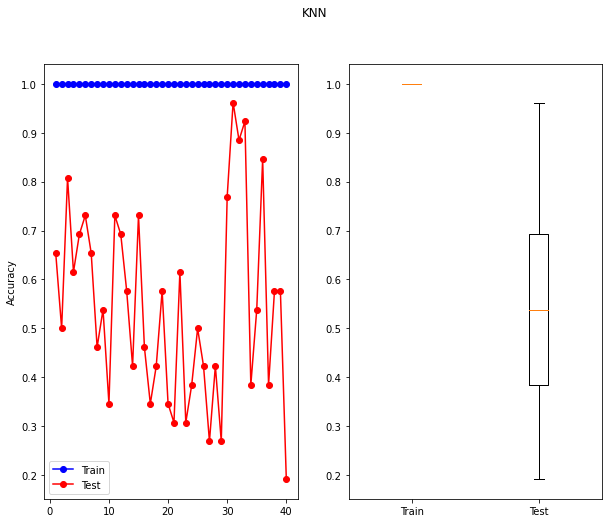

---DTC---
Average Accuracy Train: 0.734
Standard Deviation Train: 0.01
Average Accuracy Test: 0.516
Standard Deviation Test: 0.167




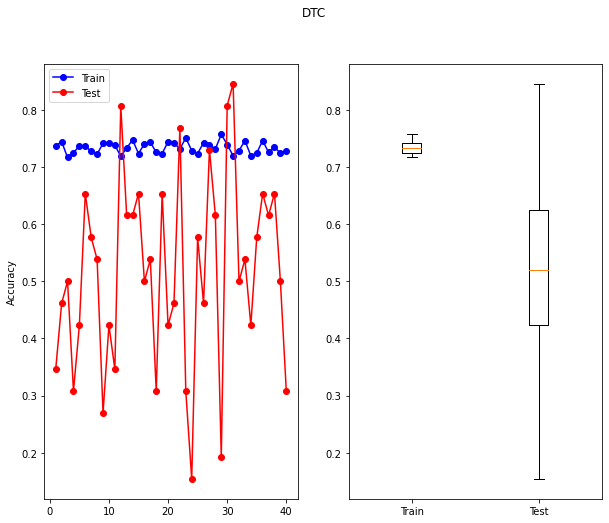

---RFC---
Average Accuracy Train: 0.909
Standard Deviation Train: 0.005
Average Accuracy Test: 0.552
Standard Deviation Test: 0.236




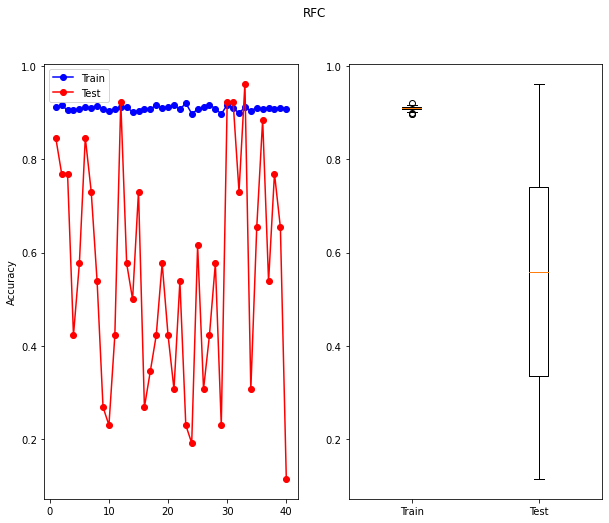

---GBT---
Average Accuracy Train: 1.0
Standard Deviation Train: 0.0
Average Accuracy Test: 0.561
Standard Deviation Test: 0.196




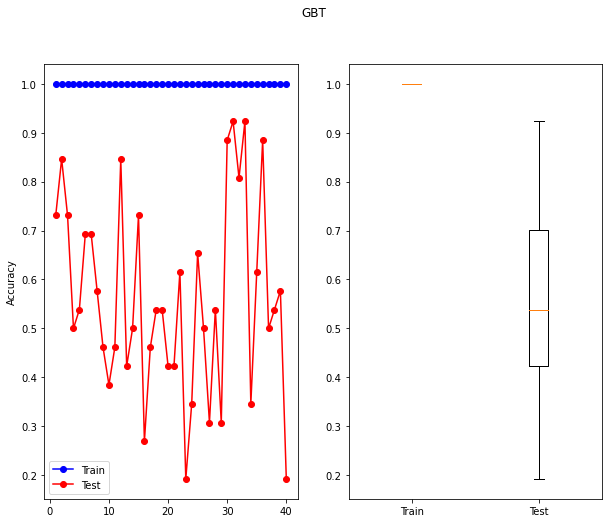

---MLP---
Average Accuracy Train: 0.713
Standard Deviation Train: 0.01
Average Accuracy Test: 0.565
Standard Deviation Test: 0.272




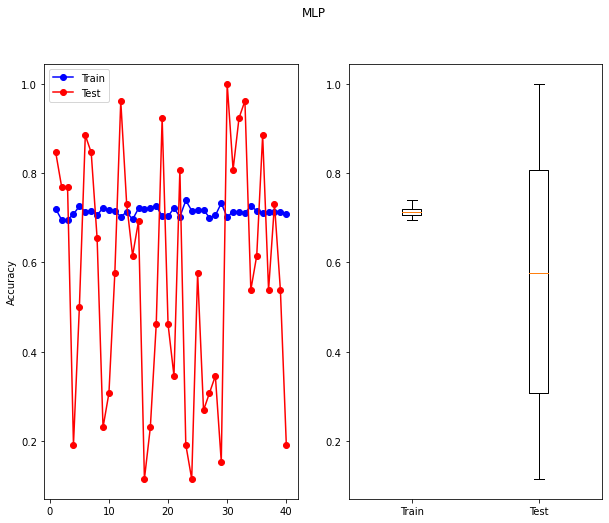

---SMV---
Average Accuracy Train: 0.675
Standard Deviation Train: 0.009
Average Accuracy Test: 0.557
Standard Deviation Test: 0.262




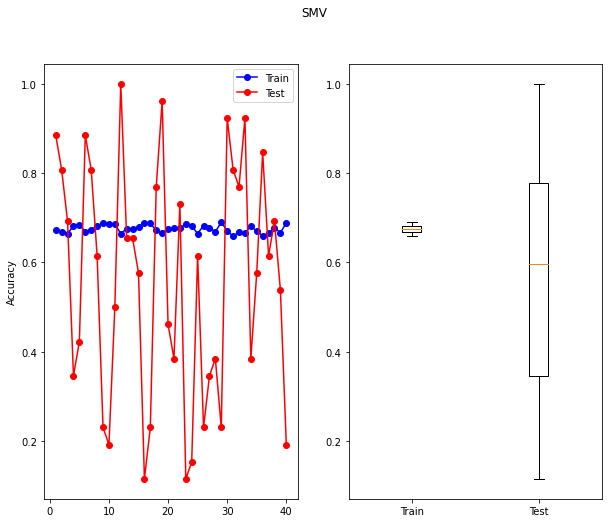

In [32]:
# Initialize the LeaveOneGroupOut method
logo = LeaveOneGroupOut()

# Itera sobre los modelos
for name, model in models:
    print(f"---\033[1m{name.upper()}\033[0m---")

    # List to store the metrics in each iteration
    accuracy_train = []
    accuracy_test = []

    # Second loop to divide in train and test with LeaveOneGroupOut
    for train_index, test_index in logo.split(X[best_features], y, groups=groups):
        
        X_train, X_test = X[best_features].iloc[train_index], X[best_features].iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Normalize the data when needing
        if name != 'DTC' and name != 'RFC':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Training the model
        model.fit(X_train, y_train)

        # Predict for the train and test subset and compute
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        
        # Evaluate and store accuracy
        accuracy_train.append(accuracy_score(y_train, y_pred_train))
        accuracy_test.append(accuracy_score(y_test, y_pred))
        
    # Compute the mean accuracy
    average_accuracy_train = np.mean(accuracy_train)
    average_accuracy_test = np.mean(accuracy_test)

    print(f'Average Accuracy Train: {round(average_accuracy_train, 3)}')
    print(f'Standard Deviation Train: {round(np.std(accuracy_train), 3)}')
    print(f'Average Accuracy Test: {round(average_accuracy_test, 3)}')
    print(f'Standard Deviation Test: {round(np.std(accuracy_test), 3)}')
    print('\n')
    
    iteraciones = list(range(1, 41))
    
    # Plot the results of the metrics with respect each iteration
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    
    axs[0].plot(iteraciones, accuracy_train, marker='o', linestyle='-', color='b', label='Train')
    axs[0].plot(iteraciones, accuracy_test, marker='o', linestyle='-', color='r', label='Test')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].boxplot([accuracy_train, accuracy_test], labels=['Train', 'Test'])
    
    fig.suptitle(name)
    plt.show()